In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("daily_mov.csv", parse_dates=["date"])

# Sort by user and date for proper time-series operations
df.sort_values(by=["user_id", "date"], inplace=True)

# Extract 'day' and 'month' from 'date'
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month

# Yesterday's mood
#df["mood_yesterday"] = df.groupby("user_id")["mood"].shift(1)

# Average mood over last 5 days
df["mood_avg_5d"] = (
    df.groupby("user_id")["mood"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Mood change from yesterday to today
#df["mood_change"] = df["mood"] - df["mood_yesterday"]

# One-hot encode the 'weekday' column
weekday_dummies = pd.get_dummies(df["weekday"], prefix="weekday")
df = pd.concat([df, weekday_dummies], axis=1)

# Drop columns: id, date, total_entries
df.drop(columns=["id", "date", "total_entries"], inplace=True)

# Save the modified dataset
df.to_csv("daily_mov_featured.csv", index=False)

print("✅ Done! Features updated and saved to 'daily_mov_featured.csv'")


✅ Done! Features updated and saved to 'daily_mov_featured.csv'


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

feature_cols = [
    'screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment',
    'appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social',
    'appCat.travel','appCat.unknown','appCat.utilities','appCat.weather','activity',
    'circumplex.arousal','circumplex.valence','mood_count',
    'weekday','day','month','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'
]

# Load dataset
df = pd.read_csv("daily_mov_featured.csv")
target = 'mood'
user_col = 'user_id'

# Normalize features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Encode user_id
df['user_id_idx'] = df[user_col].astype('category').cat.codes
num_users = df['user_id_idx'].nunique()

# Train/validation/test split
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.3, random_state=42)

# PyTorch Dataset
class MoodDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[feature_cols].values.astype('float32')
        self.moods = dataframe[target].values.astype('float32')
        self.user_ids = dataframe['user_id_idx'].values.astype('int64')

    def __len__(self):
        return len(self.moods)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx]),
            'user_id': torch.tensor(self.user_ids[idx]),
            'mood': torch.tensor(self.moods[idx]),
            'raw_user_id': int(self.user_ids[idx])
        }

# Create DataLoaders
train_loader = DataLoader(MoodDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(MoodDataset(val_df), batch_size=32)
test_loader = DataLoader(MoodDataset(test_df), batch_size=32)

# Neural Network
class MoodNN(nn.Module):
    def __init__(self, input_dim, num_users, user_emb_dim=16):
        super(MoodNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim + user_emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x, user_id):
        user_emb = self.user_embedding(user_id)
        x = torch.cat([x, user_emb], dim=1)
        return self.fc(x)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoodNN(input_dim=len(feature_cols), num_users=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopping(patience=5)

# Training loop with validation and early stopping
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device).unsqueeze(1)

        optimizer.zero_grad()
        pred = model(x, user_id)
        loss = loss_fn(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    val_preds, val_actuals = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['features'].to(device)
            user_id = batch['user_id'].to(device)
            y = batch['mood'].to(device).unsqueeze(1)
            pred = model(x, user_id)
            val_preds.extend(pred.cpu().numpy())
            val_actuals.extend(y.cpu().numpy())

    val_loss = mean_squared_error(val_actuals, val_preds, squared=False)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}, Val RMSE: {val_loss:.4f}")

    if early_stopper.step(val_loss, model):
        print("🛑 Early stopping triggered.")
        model.load_state_dict(early_stopper.best_model_state)
        break

# Evaluation
model.eval()
preds, actuals, user_ids = [], [], []
with torch.no_grad():
    for batch in test_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device).unsqueeze(1)
        raw_user_ids = batch['raw_user_id']
        pred = model(x, user_id)

        preds.extend(pred.cpu().numpy())
        actuals.extend(y.cpu().numpy())
        user_ids.extend(raw_user_ids)

preds = np.array(preds).flatten()
actuals = np.array(actuals).flatten()
user_ids = np.array(user_ids)
mask = np.isfinite(preds) & np.isfinite(actuals)
preds = preds[mask]
actuals = actuals[mask]
user_ids = user_ids[mask]

print(f"✅ Prediction count: {len(preds)}, Actual count: {len(actuals)}")

if len(preds) > 0:
    r2 = r2_score(actuals, preds)
    rmse = mean_squared_error(actuals, preds, squared=False)
    accuracy = np.mean(np.round(preds) == np.round(actuals))  # raw rounding accuracy
    print(f"\n✅ Test RMSE: {rmse:.4f}, R²: {r2:.4f}, Accuracy (rounded match): {accuracy:.4f}")

    user_results = defaultdict(list)
    for uid, pred, actual in zip(user_ids, preds, actuals):
        user_results[uid].append((pred, actual))

    print("\n📊 Per-User Accuracy:")
    for uid, values in user_results.items():
        pred_vals, actual_vals = zip(*values)
        acc = np.mean(np.round(pred_vals) == np.round(actual_vals))
        print(f"  User {uid}: Rounded Accuracy = {acc:.2f} ({len(values)} samples)")
        for i, (p, a) in enumerate(values):
            print(f"    Sample {i+1}: Predicted = {p:.2f}, Actual = {a:.2f}")
else:
    print("❌ No valid predictions to evaluate.")


Epoch 1 - Train Loss: 0.2816, Val RMSE: 0.2966
Epoch 2 - Train Loss: 0.0838, Val RMSE: 0.2179
Epoch 3 - Train Loss: 0.0711, Val RMSE: 0.2075
Epoch 4 - Train Loss: 0.0540, Val RMSE: 0.1972
Epoch 5 - Train Loss: 0.0506, Val RMSE: 0.1931
Epoch 6 - Train Loss: 0.0503, Val RMSE: 0.1845
Epoch 7 - Train Loss: 0.0435, Val RMSE: 0.1807
Epoch 8 - Train Loss: 0.0408, Val RMSE: 0.1718
Epoch 9 - Train Loss: 0.0425, Val RMSE: 0.1663
Epoch 10 - Train Loss: 0.0403, Val RMSE: 0.1667
Epoch 11 - Train Loss: 0.0362, Val RMSE: 0.1653
Epoch 12 - Train Loss: 0.0353, Val RMSE: 0.1629
Epoch 13 - Train Loss: 0.0380, Val RMSE: 0.1565
Epoch 14 - Train Loss: 0.0472, Val RMSE: 0.1551
Epoch 15 - Train Loss: 0.0339, Val RMSE: 0.1590
Epoch 16 - Train Loss: 0.0322, Val RMSE: 0.1559
Epoch 17 - Train Loss: 0.0322, Val RMSE: 0.1540
Epoch 18 - Train Loss: 0.0267, Val RMSE: 0.1533
Epoch 19 - Train Loss: 0.0313, Val RMSE: 0.1534
Epoch 20 - Train Loss: 0.0284, Val RMSE: 0.1517
Epoch 21 - Train Loss: 0.0314, Val RMSE: 0.1503
E

In [3]:
import matplotlib.pyplot as plt
import os

os.makedirs("user_plots", exist_ok=True)

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)

    # Plot and save per user
    plt.figure(figsize=(8, 4))
    plt.plot(pred_vals, label='Predicted', marker='o')
    plt.plot(actual_vals, label='Actual', marker='x')
    plt.title(f'User {uid} Mood Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Mood')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"user_plots/user_{uid}_mood_plot.png")
    plt.close()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

feature_cols = [
    'screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment',
    'appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social',
    'appCat.travel','appCat.unknown','appCat.utilities','appCat.weather','activity',
    'circumplex.arousal','circumplex.valence','mood_count',
    'weekday','day','month','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'
]

# Load dataset
df = pd.read_csv("daily_mov_featured.csv")

# Categorize mood into 3 classes
def categorize_mood(value):
    if value <= 0.5:
        return 0  # Bad
    elif value <= 0.7:
        return 1  # Neutral
    else:
        return 2  # Good

df['mood_class'] = df['mood'].apply(categorize_mood)
target = 'mood_class'
user_col = 'user_id'

# Normalize features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Encode user_id
df['user_id_idx'] = df[user_col].astype('category').cat.codes
num_users = df['user_id_idx'].nunique()

# Train/validation/test split
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# PyTorch Dataset
class MoodDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[feature_cols].values.astype('float32')
        self.moods = dataframe[target].values.astype('int64')
        self.user_ids = dataframe['user_id_idx'].values.astype('int64')

    def __len__(self):
        return len(self.moods)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx]),
            'user_id': torch.tensor(self.user_ids[idx]),
            'mood': torch.tensor(self.moods[idx]),
            'raw_user_id': int(self.user_ids[idx])
        }

# Create DataLoaders
train_loader = DataLoader(MoodDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(MoodDataset(val_df), batch_size=32)
test_loader = DataLoader(MoodDataset(test_df), batch_size=32)

# Neural Network
class MoodNN(nn.Module):
    def __init__(self, input_dim, num_users, user_emb_dim=16):
        super(MoodNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim + user_emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 3)  # 5 mood classes (Adjust the classes)
        )

    def forward(self, x, user_id):
        user_emb = self.user_embedding(user_id)
        x = torch.cat([x, user_emb], dim=1)
        return self.fc(x)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoodNN(input_dim=len(feature_cols), num_users=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=5)

# Training loop with validation and early stopping
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device)

        optimizer.zero_grad()
        pred = model(x, user_id)
        loss = loss_fn(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    val_preds, val_actuals = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['features'].to(device)
            user_id = batch['user_id'].to(device)
            y = batch['mood'].to(device)
            pred = model(x, user_id)
            val_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            val_actuals.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_actuals, val_preds)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

    if early_stopper.step(-val_acc, model):  # maximize accuracy
        print("🛑 Early stopping triggered.")
        model.load_state_dict(early_stopper.best_model_state)
        break

# Evaluation
model.eval()
preds, actuals, user_ids = [], [], []
with torch.no_grad():
    for batch in test_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device)
        raw_user_ids = batch['raw_user_id']
        pred = model(x, user_id)

        preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
        actuals.extend(y.cpu().numpy())
        user_ids.extend(raw_user_ids)

preds = np.array(preds)
actuals = np.array(actuals)
user_ids = np.array(user_ids)

print(f"✅ Prediction count: {len(preds)}, Actual count: {len(actuals)}")

if len(preds) > 0:
    acc = accuracy_score(actuals, preds)
    print(f"\n✅ Test Classification Accuracy: {acc:.4f}")

    user_results = defaultdict(list)
    for uid, pred, actual in zip(user_ids, preds, actuals):
        user_results[uid].append((pred, actual))

    print("\n📊 Per-User Classification Accuracy:")
    for uid, values in user_results.items():
        pred_vals, actual_vals = zip(*values)
        acc = np.mean(np.array(pred_vals) == np.array(actual_vals))
        print(f"  User {uid}: Accuracy = {acc:.2f} ({len(values)} samples)")
        for i, (p, a) in enumerate(values):
            mood_labels = ['Bad', 'Neutral', 'Good']
            pred_label = mood_labels[p] if 0 <= p < len(mood_labels) else 'Unknown'
            actual_label = mood_labels[a] if 0 <= a < len(mood_labels) else 'Unknown'
            print(f"    Sample {i+1}: Predicted = {p} ({pred_label}), Actual = {a} ({actual_label})")
else:
    print("❌ No valid predictions to evaluate.")


Epoch 1 - Train Loss: 0.9939, Val Accuracy: 0.7524
Epoch 2 - Train Loss: 0.7256, Val Accuracy: 0.7476
Epoch 3 - Train Loss: 0.6521, Val Accuracy: 0.7476
Epoch 4 - Train Loss: 0.5817, Val Accuracy: 0.7476
Epoch 5 - Train Loss: 0.5528, Val Accuracy: 0.7476
Epoch 6 - Train Loss: 0.5268, Val Accuracy: 0.7667
Epoch 7 - Train Loss: 0.4788, Val Accuracy: 0.7667
Epoch 8 - Train Loss: 0.4351, Val Accuracy: 0.7952
Epoch 9 - Train Loss: 0.4309, Val Accuracy: 0.7905
Epoch 10 - Train Loss: 0.3833, Val Accuracy: 0.7905
Epoch 11 - Train Loss: 0.3743, Val Accuracy: 0.8000
Epoch 12 - Train Loss: 0.3531, Val Accuracy: 0.8286
Epoch 13 - Train Loss: 0.3554, Val Accuracy: 0.8429
Epoch 14 - Train Loss: 0.3274, Val Accuracy: 0.8381
Epoch 15 - Train Loss: 0.3313, Val Accuracy: 0.8476
Epoch 16 - Train Loss: 0.2965, Val Accuracy: 0.8429
Epoch 17 - Train Loss: 0.2851, Val Accuracy: 0.8429
Epoch 18 - Train Loss: 0.2882, Val Accuracy: 0.8429
Epoch 19 - Train Loss: 0.3126, Val Accuracy: 0.8524
Epoch 20 - Train Loss

In [6]:
import matplotlib.pyplot as plt
import os

# Create a directory to store user-specific plots
os.makedirs("user_classification_plots", exist_ok=True)

mood_labels = ['Bad', 'Neutral', 'Good']

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)

    # Create figure
    plt.figure(figsize=(10, 4))
    plt.plot(actual_vals, label="Actual", linestyle='-', marker='o')
    plt.plot(pred_vals, label="Predicted", linestyle='--', marker='x')
    plt.title(f"User {uid} - Mood Class Predictions")
    plt.xlabel("Sample Index")
    plt.ylabel("Mood Class")
    plt.yticks(ticks=[0, 1, 2], labels=mood_labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"user_classification_plots/user_{uid}_mood_class.png")
    plt.close()


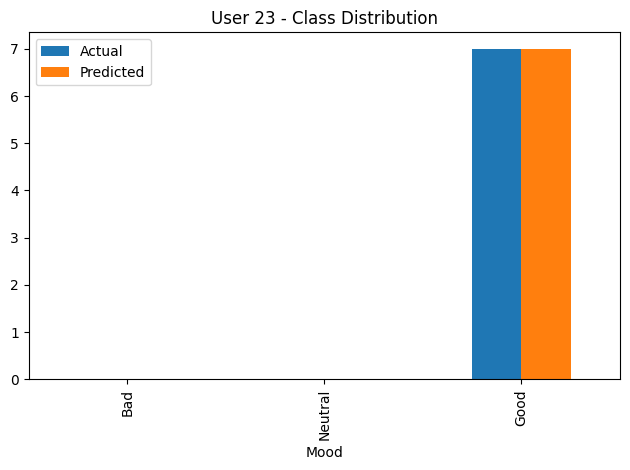

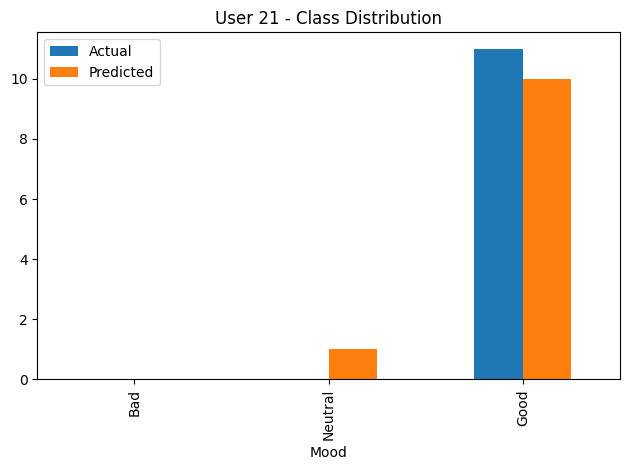

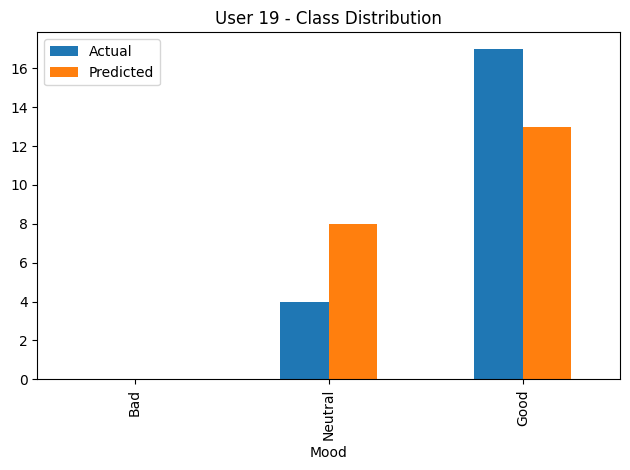

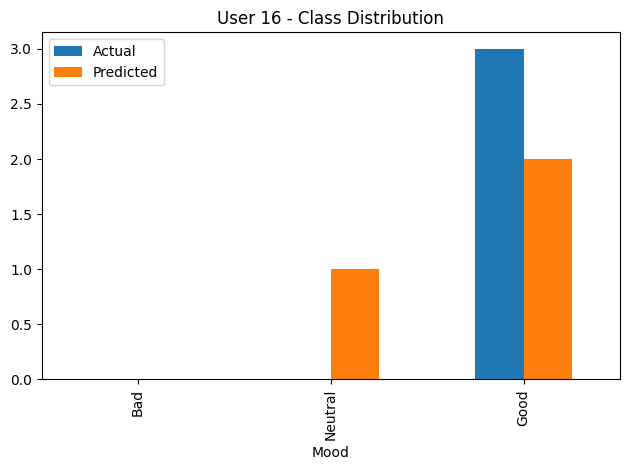

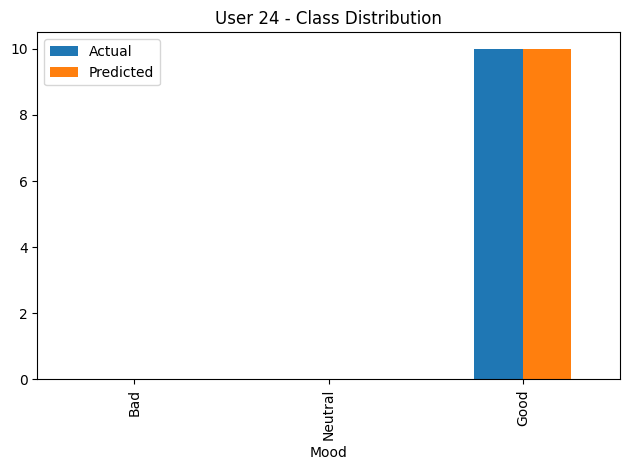

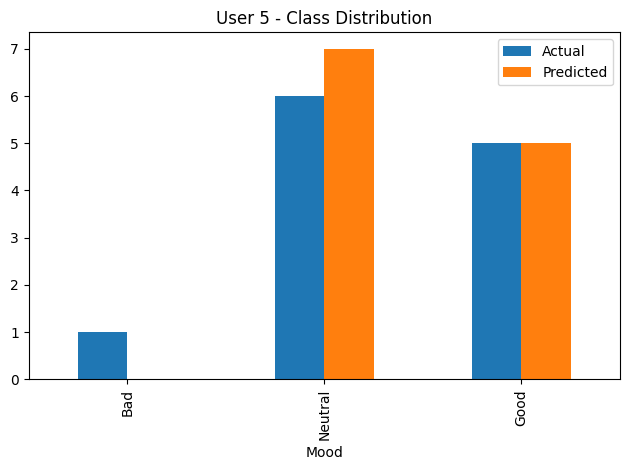

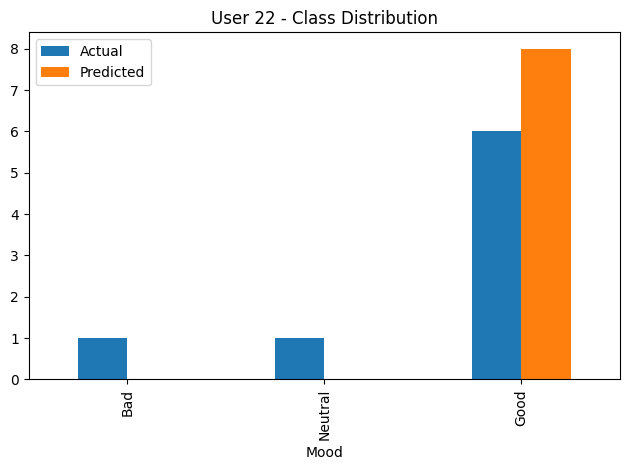

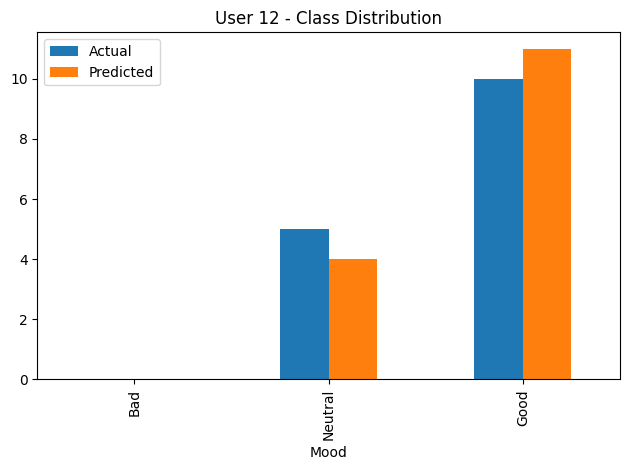

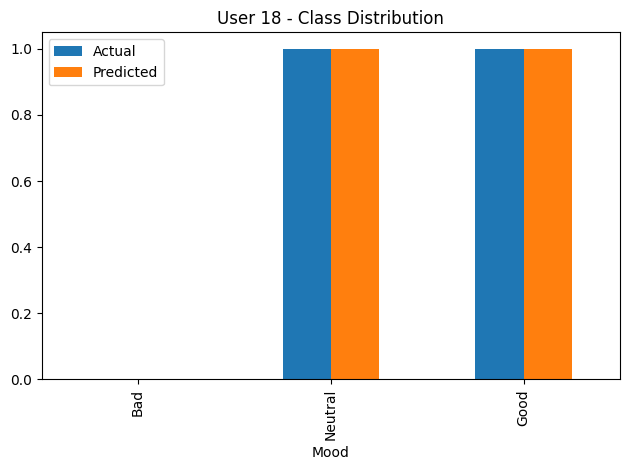

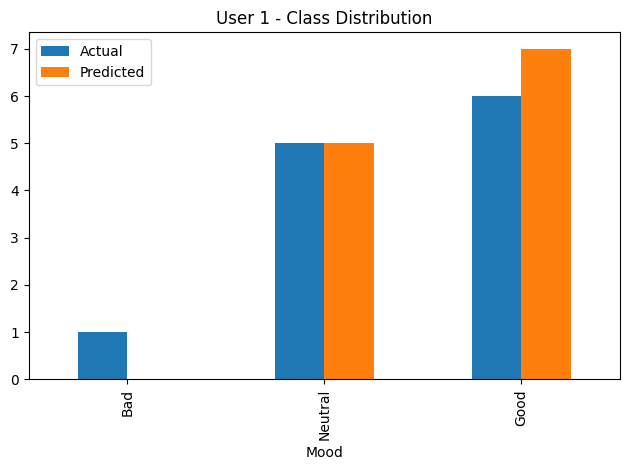

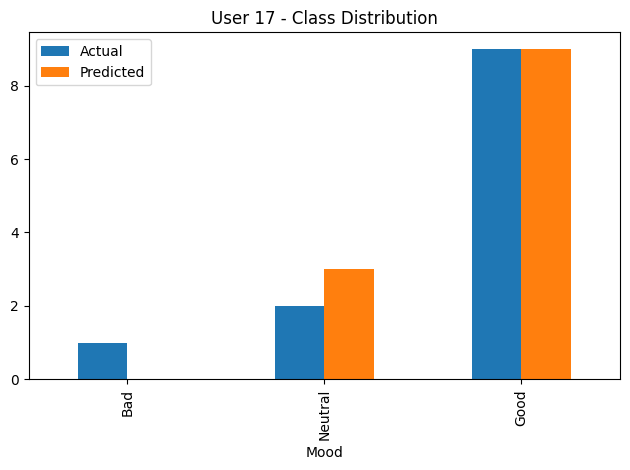

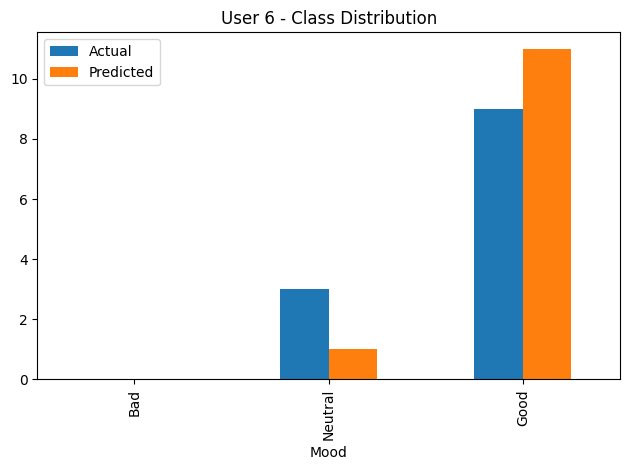

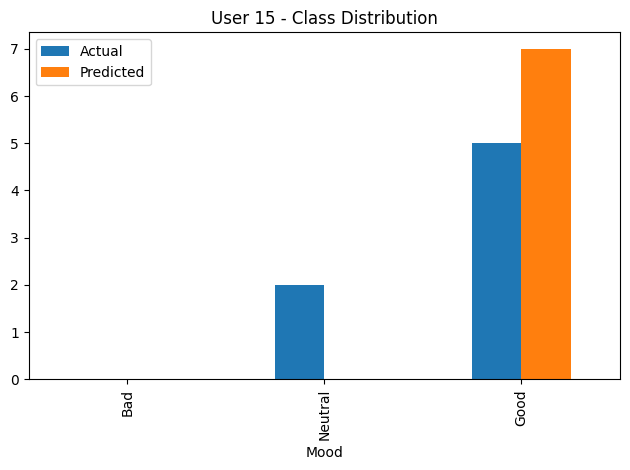

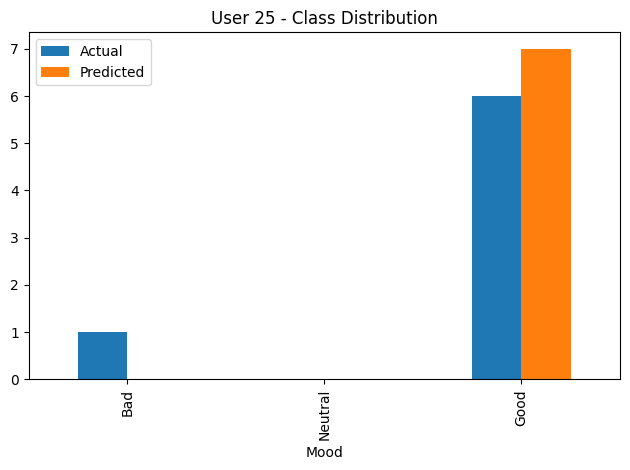

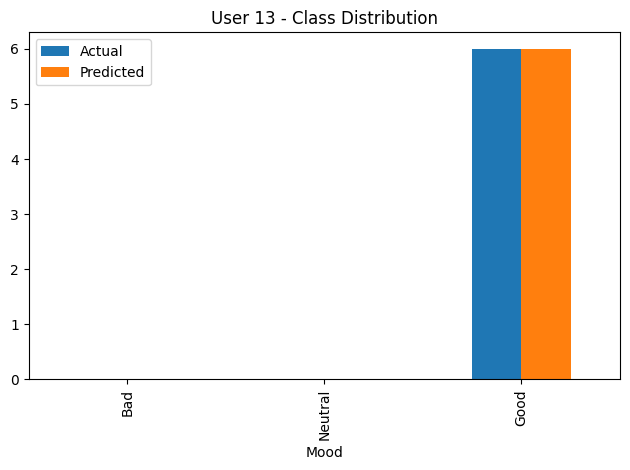

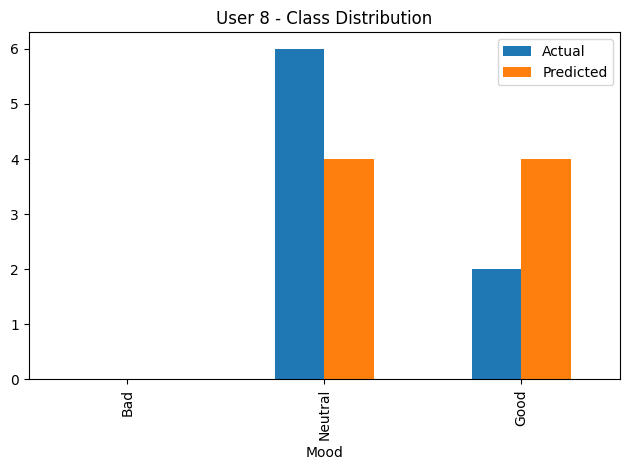

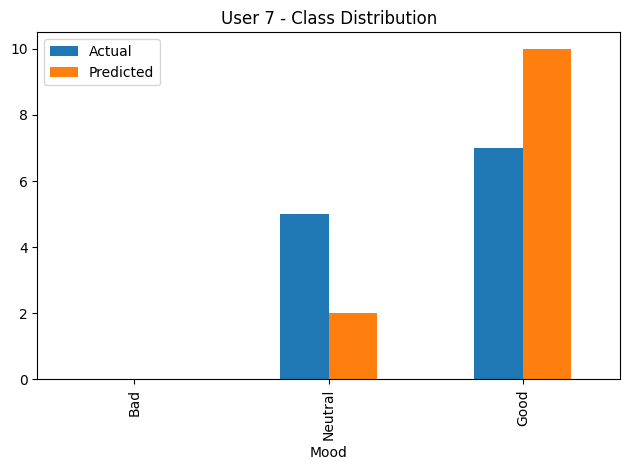

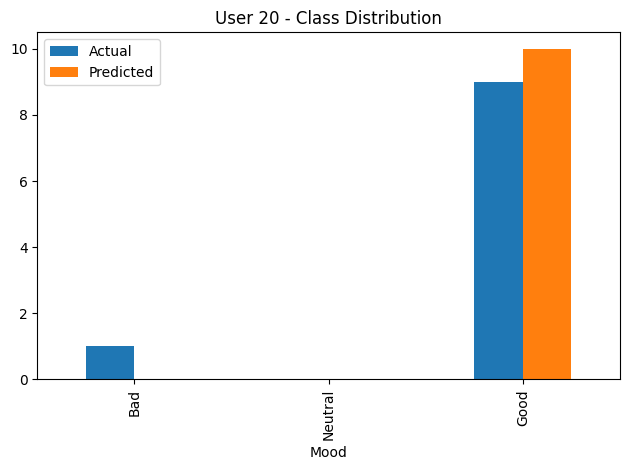

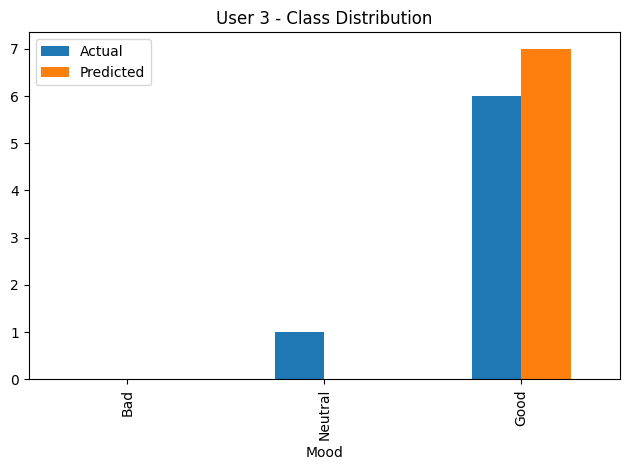

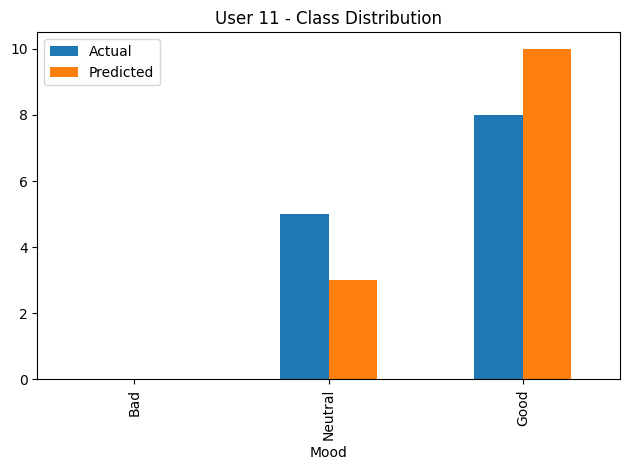

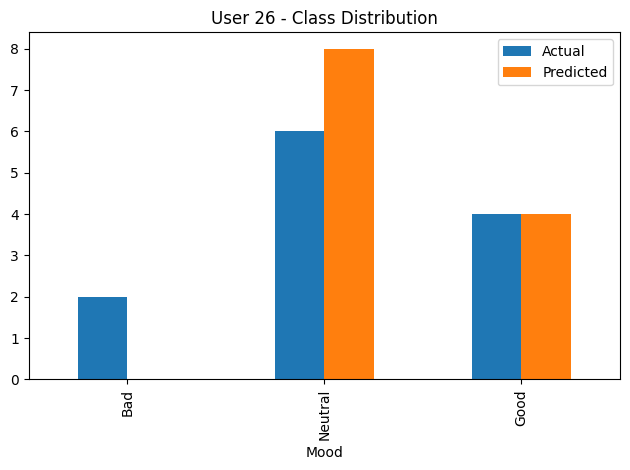

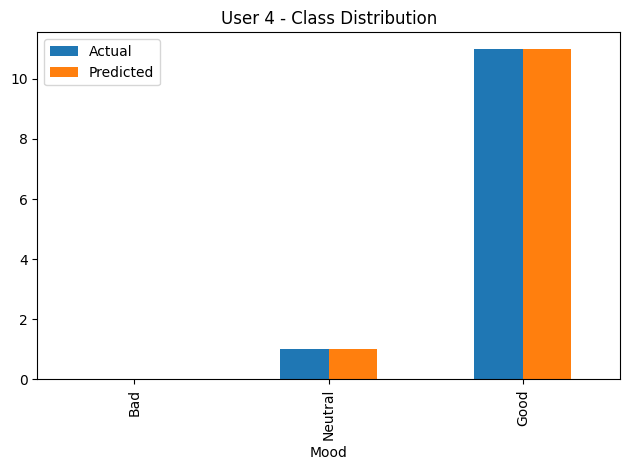

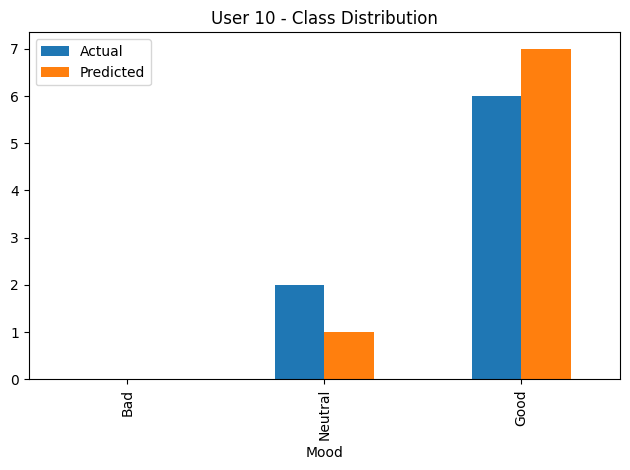

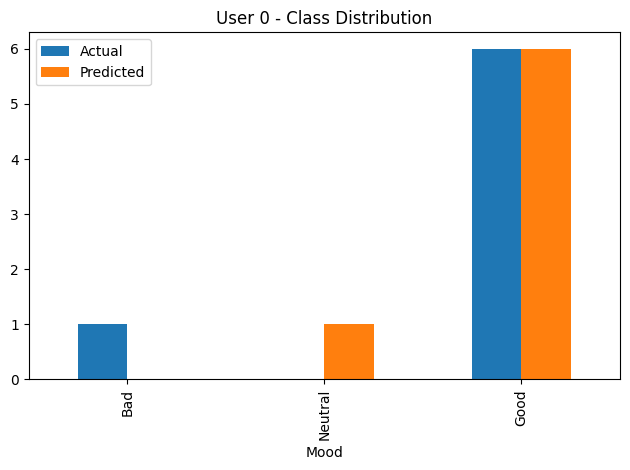

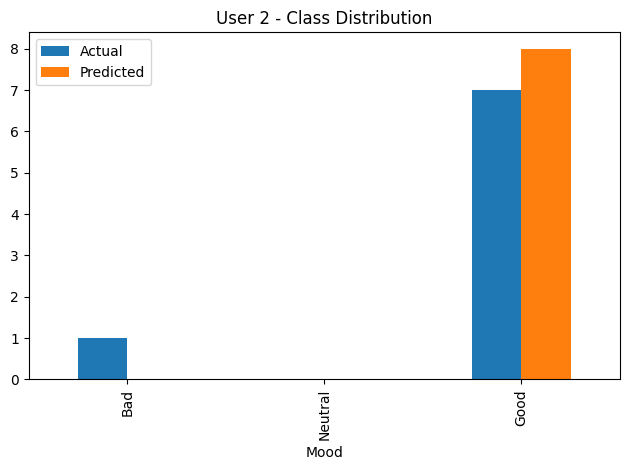

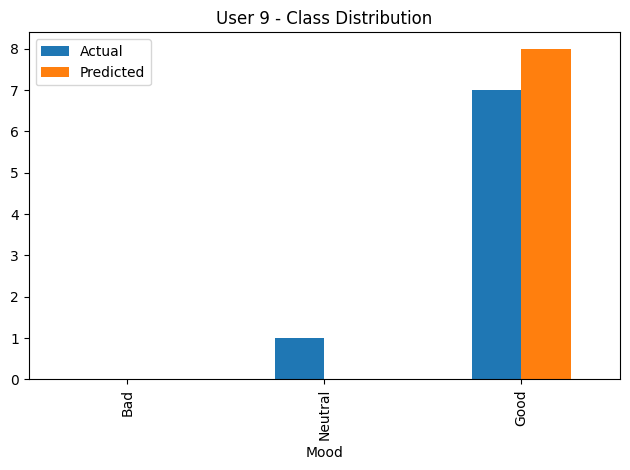

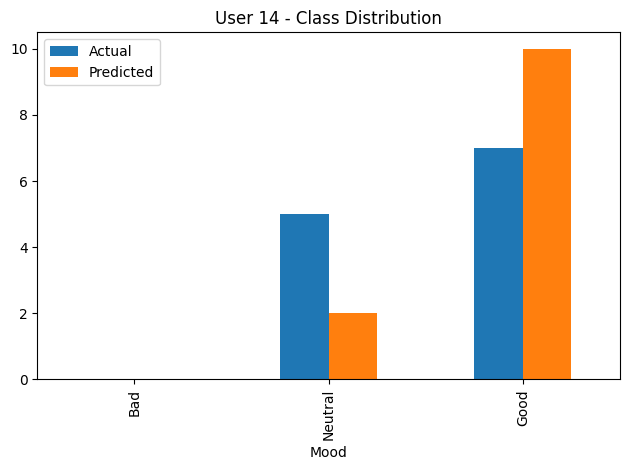

In [7]:
import seaborn as sns
from collections import Counter

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)
    count_actual = Counter(actual_vals)
    count_pred = Counter(pred_vals)
    data = pd.DataFrame({
        'Mood': ['Bad', 'Neutral', 'Good'],
        'Actual': [count_actual.get(i, 0) for i in range(3)],
        'Predicted': [count_pred.get(i, 0) for i in range(3)]
    })
    data.set_index('Mood').plot(kind='bar', title=f"User {uid} - Class Distribution")
    plt.tight_layout()
    plt.show()


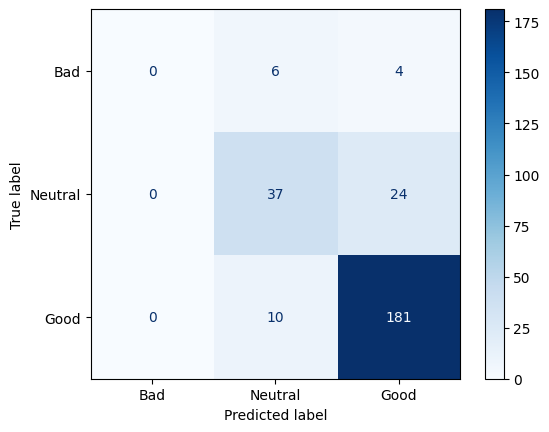

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actuals, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Neutral', 'Good'])
disp.plot(cmap="Blues")



📊 Per-User Confusion Matrices:

User 23


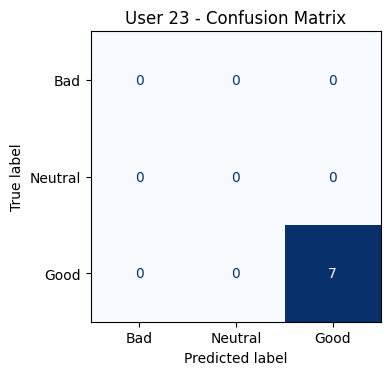


User 21


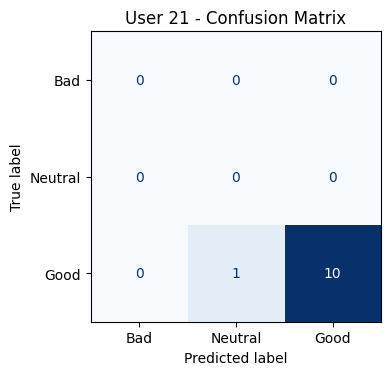


User 19


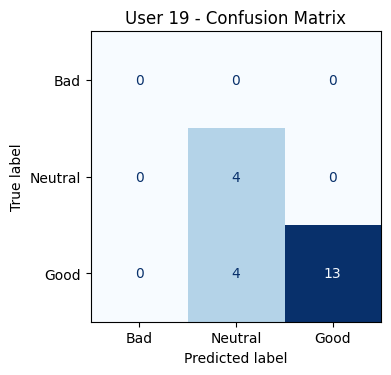


User 16


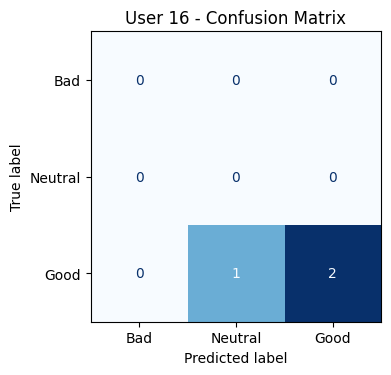


User 24


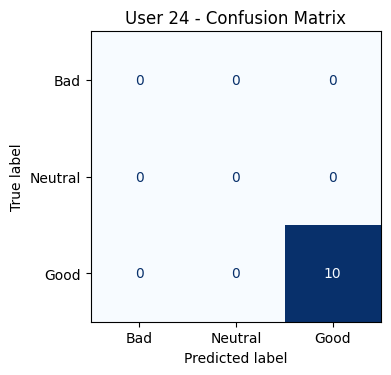


User 5


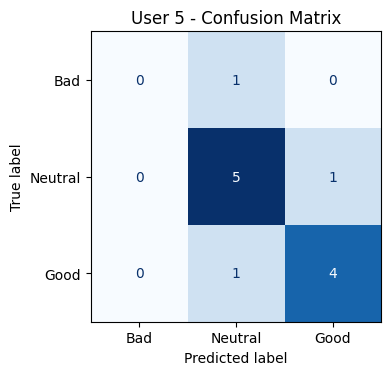


User 22


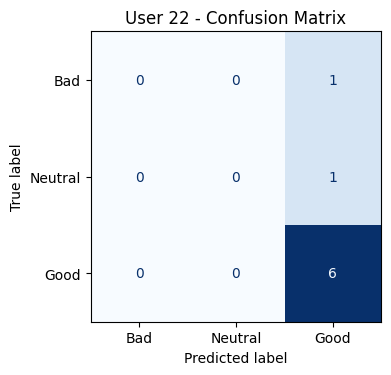


User 12


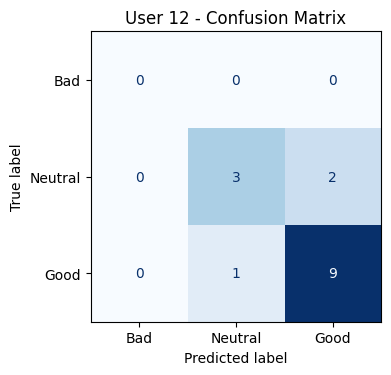


User 18


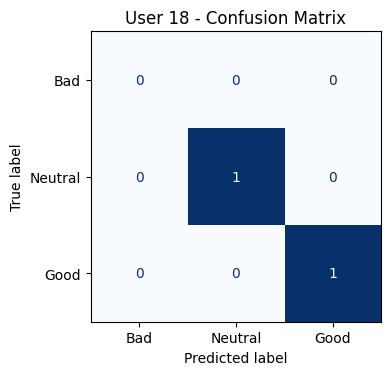


User 1


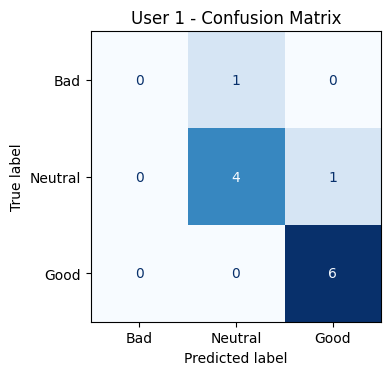


User 17


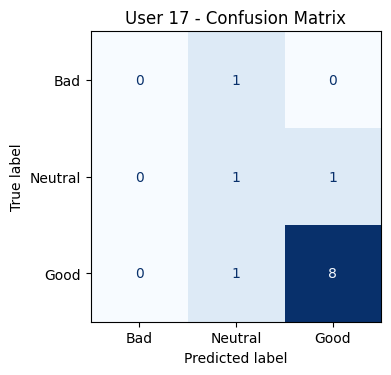


User 6


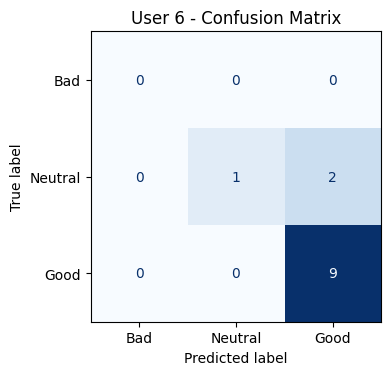


User 15


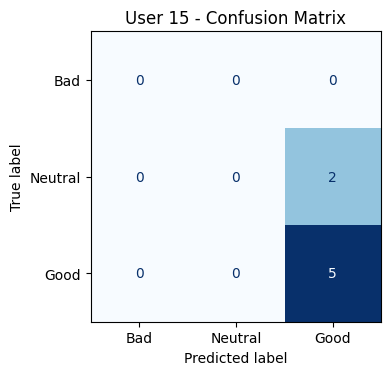


User 25


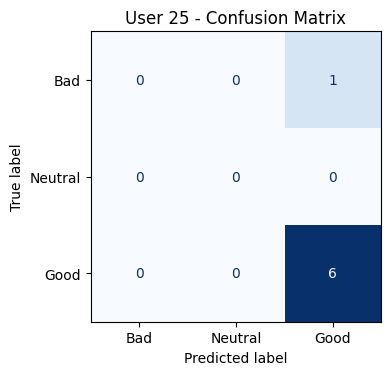


User 13


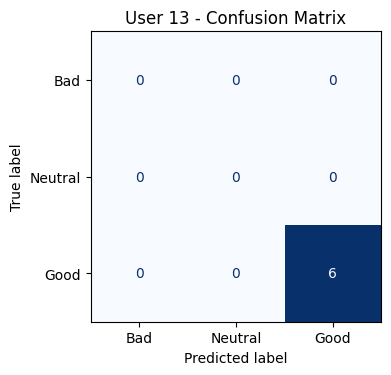


User 8


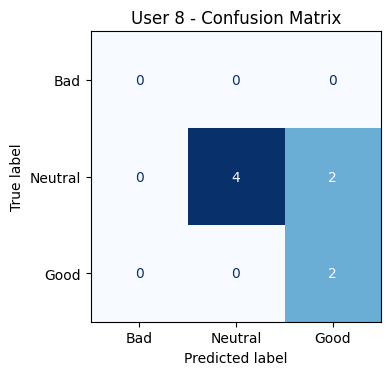


User 7


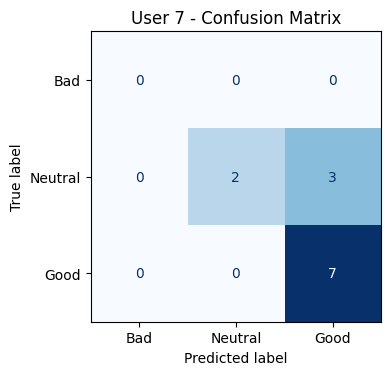


User 20


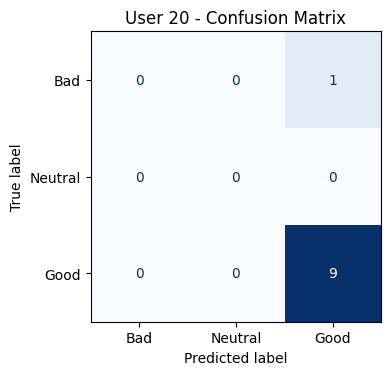


User 3


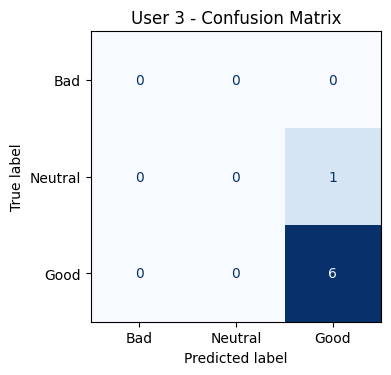


User 11


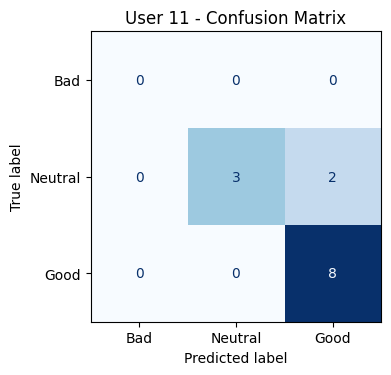


User 26


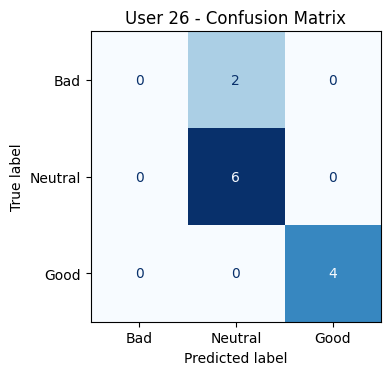


User 4


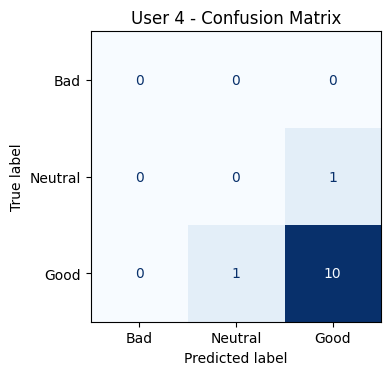


User 10


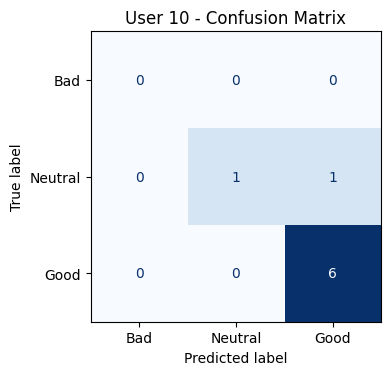


User 0


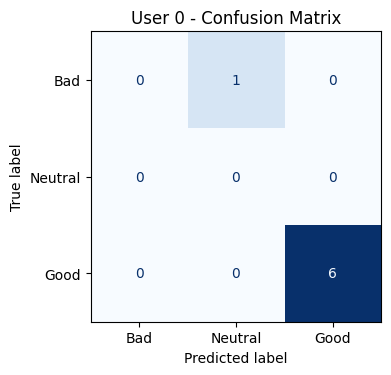


User 2


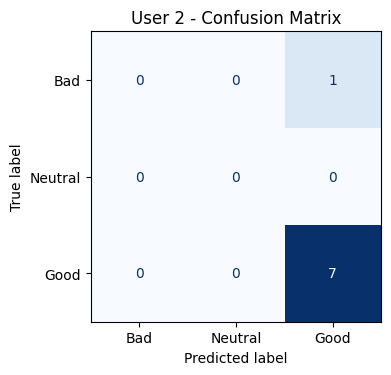


User 9


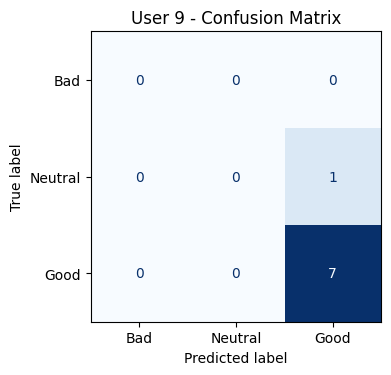


User 14


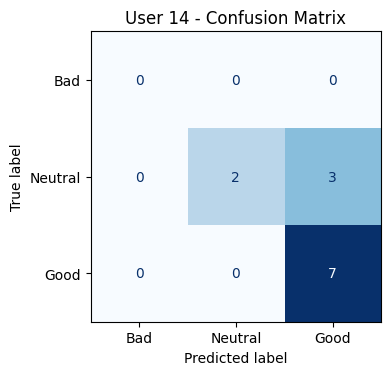

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mood_labels = ['Bad', 'Neutral', 'Good']

print("\n📊 Per-User Confusion Matrices:")

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)
    cm = confusion_matrix(actual_vals, pred_vals, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mood_labels)

    print(f"\nUser {uid}")
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    plt.title(f"User {uid} - Confusion Matrix")
    plt.tight_layout()
    plt.show()
